# EDA Version 0.2
In this approach, we will divide the dataset into 3 Big categories, and then we train each category alone. 


## 1- Importing libraries

also doing some logistics

In [0]:
!pip install Sastrawi

In [0]:
#Load all the needed libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import json
from pprint import pprint
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import datetime
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
plt.style.use('seaborn-ticks')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2- Loading Train/test data

In [0]:
path = '/content/drive/My Drive/GitHub/nsdc_beginner/Data'

#path = './Data'
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftest = pd.read_csv(os.path.join(path, 'test.csv'))


In [0]:
with open(os.path.join(path,'categories.json')) as f:
    categories = json.load(f)

pprint(categories)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
            

## 3- Feature Engineering

### 3.1 Divide the training data into Big categories containers (Beauty/Fashion/Mobile)

In [0]:
# 1. add a new col that contins the big category (beauty, fashion, mobile)

newCol = dftrain.image_path.apply(lambda x : x.split('_')[0])
dftrain['mainCat'] = newCol
# dftrain.head()

Check for unique values

In [0]:
set(dftrain['mainCat'])

{'beauty', 'fashion', 'mobile'}

### 3.2 Display the total number of samples under each category

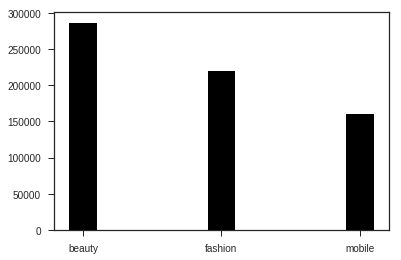

In [0]:
Beautydf= dftrain[dftrain['mainCat'] == 'beauty']
Fashiondf= dftrain[dftrain['mainCat'] == 'fashion']
Mobiledf= dftrain[dftrain['mainCat'] == 'mobile']

plt.bar(['beauty', 'fashion', 'mobile'],[Beautydf.shape[0],Fashiondf.shape[0],Mobiledf.shape[0]],width=0.2, color='black');

#### 3.2.1 EDA

In [0]:
Fashiondf.head()

,itemid,title,Category,image_path,mainCat
286583,2282553,retro floral dress,17,fashion_image/78d17fdb159bba51a4250dc3d583245e,fashion
286584,13822218,dress floral sifon,18,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,fashion
286585,33555935,korean white chiffon collar dress,18,fashion_image/6dbe2e7cba5ddbb750d2144d8f248f11,fashion
286586,65755120,women s trendy apricot o neck solid chiffon bl...,19,fashion_image/dc9b21429604148fc0342d12694f3294,fashion
286587,65857438,big sale baju gamis pesta india aysilla pancar...,20,fashion_image/6c25c578dd8edce742a805f891f1a51f,fashion


In [0]:
Fashiondf.shape

(219702, 5)

### 3.3 Randomize the train-dataset

To avoid bias in the training dataset, it is a good practice

In [0]:
Beautydf.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            286573, 286574, 286575, 286576, 286577, 286578, 286579, 286580,
            286581, 286582],
           dtype='int64', length=286583)

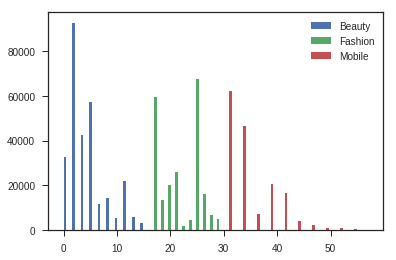

In [0]:
# randomize datasets

Beautydf = Beautydf.reindex(np.random.permutation(Beautydf.index))
Fashiondf = Fashiondf.reindex(np.random.permutation(Fashiondf.index))
Mobiledf = Mobiledf.reindex(np.random.permutation(Mobiledf.index))

# Beautydf.Category.hist(width = 0.5)
# Fashiondf.Category.hist(width = 0.5)
# Mobiledf.Category.hist(width = 0.5)

fig, catAx = plt.subplots(1, 1)

catAx.hist(Beautydf.Category, label='Beauty', width=0.5)
catAx.hist(Fashiondf.Category, label='Fashion', width=0.5)
catAx.hist(Mobiledf.Category , label='Mobile', width=0.5)

catAx.legend()
plt.show()

### 3.4 Remove any number with more than 3 digits in the dataset

For example : `02854323232` which could be an id or something


In [0]:
# Remove any number in the dataset with more than or equal to 3 digits. 

Beautydf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Fashiondf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Mobiledf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)

615941    refurbished apple iphone 5s lcd display touch ...
578078                              asus zenfone max pro m1
601134                                     advan hammer r1s
514082                               apple iphone xs  ready
605118    promo lagi cuci gudang samsung galaxy s8 resmi...
589695    big promo 80 discount wa:   oppo f3 ram 4gb in...
647802    hp asiafone af 28 af28 lazerpad new garansi 1 ...
512838    wa  big promo cuci gudang xiaomi note 5a prime...
514988    on sale xiaomi mi a1 4 u002f32gb black garansi...
534017             tempered glass sony xperia x performance
608112               promo samsung j2 prime ram 1.5 16gb   
665997    special promo hut ke 7 handphone aksesoris iph...
560416    unlocked nokia  mobile phone 2g gsm support ru...
549388    promo asus zenfone max pro m1 zb602kl 3gb.32gb...
563281    big sale up to 80 off xiaomi note 5 ram 3gb in...
533930               promo iphone 6s 64gb ex japan langsung
515738    ready stock promo murah khusus

In [0]:
Fashiondf['Category'].value_counts()

18    56598
25    33922
26    33845
20    19978
27    16199
22    15225
19    13493
21    10483
28     6493
24     4251
29     3338
17     2765
23     1671
30     1441
Name: Category, dtype: int64

#### 3.5.1 Check the phrase of the length

#### 3.8 Remove the top common words across all categories which may not be helping with the classification

## 4- Cross Validation

### 4.1 Split the training dataset into train/test

In [0]:
B_X_train = Beautydf.title
B_y_train = Beautydf.Category

F_X_train = Fashiondf.title
F_y_train = Fashiondf.Category

M_X_train = Mobiledf.title
M_y_train = Mobiledf.Category

In [0]:
def tokenize_data(vect, X_train, X_test):
    ''' Tokenize the training and test set'''
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # print the number of features that were generated
    #print('Features: ', X_train_dtm.shape[1])
    
    return X_train_dtm, X_test_dtm

In [0]:
skfolds = StratifiedKFold(n_splits=5, random_state=42)
for train_index, test_index in skfolds.split(M_X_train, M_y_train):
    y_train_folds = M_y_train.iloc[train_index]


In [0]:
from time import monotonic
from datetime import timedelta
import sklearn.metrics as metrics
import sys

def trainCV(X_train, y_train, vect, folds = 5, random_state=42, 
            clf=SGDClassifier(random_state=42, max_iter=5000, tol=1e-3, 
                              loss='hinge', verbose=1)):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)

    skfolds = StratifiedKFold(n_splits=folds, random_state=random_state)

    cv_start_time = monotonic()
    
    scores = []
    features = []
    for train_index, test_index in skfolds.split(X_train, y_train):
        start_time = monotonic()
        
        clone_clf = clone(clf)
        #X_train_folds = X_train[train_index]
        y_train_folds = y_train.iloc[train_index]
        #X_test_fold = X_train[test_index]
        y_test_fold = y_train.iloc[test_index]
        
        X_train_folds,X_test_fold = tokenize_data(vect, 
                                                  X_train.iloc[train_index], 
                                                  X_train.iloc[test_index])
        features.append(X_train_folds.shape[1])
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        scores.append(n_correct / len(y_pred))
        
        end_time = monotonic()
        print("Training time per fold: {}".format(timedelta(seconds=end_time - start_time)))

        
    print ("Features: {}".format(features))
    print("Features variance: %0.2f (+/- %0.2f)" % (np.mean(features), 
                                                    np.std(features) * 2))
    print ("Scores: {}".format(scores))
    print("Accuracy: %0.5f (+/- %0.5f)" % (np.mean(scores), 
                                           np.std(scores) * 2))
    
    cv_end_time = monotonic()
    print("Total Training time: {}".format(timedelta(seconds=cv_end_time - cv_start_time)))
    
    return clone_clf, scores, features

### 4.2 Defining Stop words

In [0]:
# Adding Bahaya Stop words 

factory = StopWordRemoverFactory()
id_stopwords = factory.get_stop_words()
en_stopwords  = list(stopwords.words('english'))
stopwords = id_stopwords + en_stopwords
stopwords[1:20]

#F_stopWords = ['dress', 'lengan', 'wanita', 'women', 'untuk', 'neck', 'model', 'top', 'panjang']
#F_stopWords2 = ['lengan', 'untuk', 'neck', 'model', 'top', 'panjang']
#F_stopWords3 = ['untuk', 'neck', 'model', 'top', 'panjang']
#B_stopWords = ['lip', 'cream', 'promo', 'bb', 'original', 'cushion', 'ml', 'natural', 'nature', 'murah']

['untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena']

### 4.3 Model Training for Beauty

#### 4.3.1 Optiming for nrange

Optimal hyperparam is at nrange 1,8 with Accuracy: 0.78536 (+/- 0.00335)

With slight improvement seen using One vs Rest with Accuracy: 0.78557 (+/- 0.00376)

And with stop words Accuracy: 0.78435 (+/- 0.00327)

* Features: [2060519, 2059314, 2055361, 2059141, 2059118]
* Features variance: 2058690.60 (+/- 3487.51)
* Scores: [0.7866127034523664, 0.787446355674959, 0.7855958965053998, 0.784320910106086, 0.7857579088799316]
* Accuracy: 0.78595 (+/- 0.00210)
* Total Training time: 0:04:07.240765

#### 4.4.2 Training for Optimal Model for Mobile

Optimal hyperparam for Mobile is with nrange of 1,5 with Accuracy: 0.82828 (+/- 0.00265)

Using One vs Rest is seeing slight improvement with Accuracy: 0.82856 (+/- 0.00143).

And with stop words: Accuracy: 0.82006 (+/- 0.00239).

* Features: [1030842, 1029869, 1029107, 1030184, 1027609]
* Features variance: 1029522.20 (+/- 2215.01)
* Scores: [0.8285375814446488, 0.8311040438998535, 0.8259784812100421, 0.8314981752394024, 0.8282692787621662]
* Accuracy: 0.82908 (+/- 0.00405)
* Total Training time: 0:02:20.155520

### 4.5 Model Training for Fashion

#### 4.5.1 Optiming for the nrange for Fashion

Optimal for Fashion is Ngram range of 1,14 with Accuracy: 0.64612 (+/- 0.00261)

And using One vs Rest with Accuracy: 0.64587 (+/- 0.00192).

With stop words with Accuracy: 0.64569 (+/- 0.00502).

Using RandomizedGridSearch
* Features: [2574193, 2573700, 2572438, 2571429, 2575672]
* Features variance: 2573486.40 (+/- 2919.42)
* Scores: [0.6499567651208301, 0.6513210295155087, 0.6532929771061854, 0.6549754187909687, 0.6576988733356094]
* Accuracy: 0.65345 (+/- 0.00545)
* Total Training time: 0:04:32.68714

#### 4.5.2 Find Optimal Model for Fashion

Best count vectorizer param appears to be at min df =1, max df = 0.6 and max features at 100,000.

#### 4.5.5 Testing stemming next

### 1.0 Fashion Optimization

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score

params = {
    #"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.00001, 0.0001, 0.001, 0.01, 0.1],
    #"penalty" : ["l2", "l1", "none"],
    "max_iter" : [1000, 5000]
}

n_iter_search = 10
model = SGDClassifier(tol=1e-3, penalty='l2', loss='hinge')
clf = RandomizedSearchCV(model, 
                         param_distributions=params, 
                         cv=5,
                   scoring='accuracy',
                   error_score='raise',
                   verbose =2,
                   n_jobs=-1,
                   n_iter=n_iter_search,
                  #loss="hinge",
                  #penalty="l2"
                  )

In [0]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
F_vect = CountVectorizer(ngram_range=(1,6), analyzer='word')
Fs_vect = CountVectorizer(ngram_range=(1,6), stop_words=stopwords, analyzer='word')


In [0]:
from sklearn.model_selection import train_test_split
from time import time

def randomSearch(X, y, vect):
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                               test_size=0.33, random_state=42)
  
  X_train_dtm, X_test_dtm = tokenize_data(vect, X_train, X_test)
  
  start = time()

  clf.fit(X_train_dtm, y_train)

  print("RandomizedSearchCV took %.2f seconds for %d candidates"
        " parameter settings." % ((time() - start), n_iter_search))
  report(clf.cv_results_)
  
  return clf

def printBestScore(clf):
  print("Best score {}".format(clf.best_score_))
  print("Best estimator {}".format(clf.best_estimator_))

In [0]:
clf = randomSearch(F_X_train, F_y_train, Fs_vect)

In [0]:
printBestScore(clf)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.7min finished


RandomizedSearchCV took 601.57 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.636 (std: 0.001)
Parameters: {'max_iter': 1000, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.636 (std: 0.002)
Parameters: {'max_iter': 5000, 'alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.618 (std: 0.004)
Parameters: {'max_iter': 5000, 'alpha': 1e-05}



0.6362092391304348


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


Running using the best model

In [0]:
bestModel = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=2, warm_start=False)

In [0]:
Fo_sgd, Fo_scores, Fo_features = trainCV(F_X_train, F_y_train, vect=Fs_vect, 
                                         clf=bestModel)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 67.74, NNZs: 979650, Bias: -2.236021, T: 175756, Avg. loss: 1.096865Norm: 18.57, NNZs: 96877, Bias: -1.485204, T: 175756, Avg. loss: 0.064585

Total training time: 0.26 seconds.
Total training time: 0.26 seconds.
-- Epoch 2
-- Epoch 2
Norm: 14.61, NNZs: 131030, Bias: -1.450341, T: 351512, Avg. loss: 0.022885
Total training time: 0.45 seconds.
Norm: 53.80, NNZs: 1302061, Bias: -1.954025, T: 351512, Avg. loss: 0.318282
Total training time: 0.45 seconds.
-- Epoch 3-- Epoch 3

Norm: 49.77, NNZs: 1438543, Bias: -1.798014, T: 527268, Avg. loss: 0.242229
Total training time: 0.60 seconds.
-- Epoch 4
Norm: 13.18, NNZs: 160440, Bias: -1.427831, T: 527268, Avg. loss: 0.018485
Total training time: 0.62 seconds.
-- Epoch 4
Norm: 48.02, NNZs: 1515172, Bias: -1.691103, T: 703024, Avg. loss: 0.208667
Total training time: 0.75 seconds.
-- Epoch 5
Norm: 12.49, NNZs: 186778, Bias: -1.408409, T: 703024, Avg. loss: 0.016547
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 46

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   23.6s finished


Training time per fold: 0:00:55.264467


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 18.59, NNZs: 96066, Bias: -1.664410, T: 175759, Avg. loss: 0.064111
Total training time: 0.22 seconds.
-- Epoch 2
Norm: 68.01, NNZs: 984442, Bias: -2.200137, T: 175759, Avg. loss: 1.110344
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 14.69, NNZs: 130488, Bias: -1.610404, T: 351518, Avg. loss: 0.023267
Total training time: 0.43 seconds.
-- Epoch 3
Norm: 54.05, NNZs: 1308153, Bias: -1.924341, T: 351518, Avg. loss: 0.318244
Total training time: 0.49 seconds.
-- Epoch 3
Norm: 13.23, NNZs: 159199, Bias: -1.570353, T: 527277, Avg. loss: 0.018625
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 49.90, NNZs: 1443466, Bias: -1.770331, T: 527277, Avg. loss: 0.241214
Total training time: 0.75 seconds.
-- Epoch 4
Norm: 12.50, NNZs: 184857, Bias: -1.545562, T: 703036, Avg. loss: 0.016508
Total training time: 0.84 seconds.
-- Epoch 5
Norm: 48.05, NNZs: 1520416, Bias: -1.671396, T: 703036, Avg. loss: 0.207831
Total training time: 1.01 seconds.
-- Epoch 5
Norm: 12

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   23.7s finished


Training time per fold: 0:00:54.174430


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 18.58, NNZs: 97455, Bias: -1.517549, T: 175760, Avg. loss: 0.068792
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 67.99, NNZs: 985150, Bias: -2.011605, T: 175760, Avg. loss: 1.121209
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 14.65, NNZs: 131801, Bias: -1.475867, T: 351520, Avg. loss: 0.023157
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 54.06, NNZs: 1309605, Bias: -1.777847, T: 351520, Avg. loss: 0.319811
Total training time: 0.50 seconds.
-- Epoch 3
Norm: 13.15, NNZs: 159543, Bias: -1.446973, T: 527280, Avg. loss: 0.018604
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 49.86, NNZs: 1449188, Bias: -1.643609, T: 527280, Avg. loss: 0.242409
Total training time: 0.76 seconds.
-- Epoch 4
Norm: 12.51, NNZs: 186054, Bias: -1.425216, T: 703040, Avg. loss: 0.016680
Total training time: 0.94 seconds.
-- Epoch 5
Norm: 47.98, NNZs: 1525744, Bias: -1.563085, T: 703040, Avg. loss: 0.209241
Total training time: 1.03 seconds.
-- Epoch 5
Norm: 12

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   24.3s finished


Training time per fold: 0:00:54.629255


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 67.89, NNZs: 981734, Bias: -2.281738, T: 175766, Avg. loss: 1.112183
Total training time: 0.25 seconds.
Norm: 18.60, NNZs: 96841, Bias: -1.566979, T: 175766, Avg. loss: 0.070122
Total training time: 0.25 seconds.
-- Epoch 2
-- Epoch 2
Norm: 14.63, NNZs: 130579, Bias: -1.522376, T: 351532, Avg. loss: 0.022952
Total training time: 0.50 seconds.
Norm: 54.00, NNZs: 1302289, Bias: -1.975545, T: 351532, Avg. loss: 0.319701
Total training time: 0.50 seconds.
-- Epoch 3
-- Epoch 3
Norm: 13.18, NNZs: 160054, Bias: -1.486459, T: 527298, Avg. loss: 0.018542
Total training time: 0.74 seconds.
Norm: 49.92, NNZs: 1440780, Bias: -1.811767, T: 527298, Avg. loss: 0.241804-- Epoch 4
Total training time: 0.75 seconds.

-- Epoch 4
Norm: 12.46, NNZs: 186371, Bias: -1.463629, T: 703064, Avg. loss: 0.016592
Total training time: 1.00 seconds.
Norm: 48.04, NNZs: 1517378, Bias: -1.709239, T: 703064, Avg. loss: 0.209587
Total training time: 1.00 seconds.
-- Epoch 5
-- Epoch 5
Norm: 12

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   23.3s finished


Training time per fold: 0:00:54.099104


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1-- Epoch 1

Norm: 68.01, NNZs: 985874, Bias: -2.190912, T: 175767, Avg. loss: 1.117962Norm: 18.66, NNZs: 96294, Bias: -1.576140, T: 175767, Avg. loss: 0.067415
Total training time: 0.24 seconds.

Total training time: 0.24 seconds.
-- Epoch 2
-- Epoch 2
Norm: 14.69, NNZs: 130733, Bias: -1.524969, T: 351534, Avg. loss: 0.023516
Total training time: 0.49 seconds.
Norm: 54.10, NNZs: 1310605, Bias: -1.916855, T: 351534, Avg. loss: 0.321375
Total training time: 0.49 seconds.
-- Epoch 3
-- Epoch 3
Norm: 13.21, NNZs: 159330, Bias: -1.496036, T: 527301, Avg. loss: 0.018521
Total training time: 0.73 seconds.
-- Epoch 4
Norm: 49.95, NNZs: 1446524, Bias: -1.761917, T: 527301, Avg. loss: 0.243001
Total training time: 0.75 seconds.
-- Epoch 4
Norm: 12.54, NNZs: 186495, Bias: -1.472955, T: 703068, Avg. loss: 0.016556
Total training time: 0.98 seconds.
-- Epoch 5
Norm: 48.12, NNZs: 1522415, Bias: -1.668444, T: 703068, Avg. loss: 0.210098
Total training time: 1.01 seconds.
-- Epoch 5
Norm: 12

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   23.9s finished


Training time per fold: 0:00:54.394605
Features: [2574193, 2573700, 2572438, 2571429, 2575672]
Features variance: 2573486.40 (+/- 2919.42)
Scores: [0.6499567651208301, 0.6513210295155087, 0.6532929771061854, 0.6549754187909687, 0.6576988733356094]
Accuracy: 0.65345 (+/- 0.00545)
Total Training time: 0:04:32.687141


### 2.0 For Beauty

In [0]:
B_vect = CountVectorizer(ngram_range=(1,8))
Bs_vect = CountVectorizer(ngram_range=(1,8), stop_words=stopwords)

In [0]:
B_clf = randomSearch(B_X_train, B_y_train, Bs_vect)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.7min finished


RandomizedSearchCV took 661.90 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.779 (std: 0.001)
Parameters: {'max_iter': 1000, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.779 (std: 0.002)
Parameters: {'max_iter': 5000, 'alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.763 (std: 0.002)
Parameters: {'max_iter': 5000, 'alpha': 1e-05}



In [0]:
printBestScore(B_clf)

Best score 0.779063590437998
Best estimator SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
B_bestModel = B_clf.best_estimator_

In [0]:
Bo_sgd, Bo_scores, Bo_features = trainCV(B_X_train, B_y_train, vect=Bs_vect, 
                                         clf=B_bestModel)

Training time per fold: 0:00:49.246299
Training time per fold: 0:00:48.549019
Training time per fold: 0:00:49.954534
Training time per fold: 0:00:48.495902
Training time per fold: 0:00:50.805365
Features: [2060519, 2059314, 2055361, 2059141, 2059118]
Features variance: 2058690.60 (+/- 3487.51)
Scores: [0.7866127034523664, 0.787446355674959, 0.7855958965053998, 0.784320910106086, 0.7857579088799316]
Accuracy: 0.78595 (+/- 0.00210)
Total Training time: 0:04:07.240765


### 3.0 For Mobile

In [0]:
Ms_vect = CountVectorizer(ngram_range=(1,5), stop_words=stopwords)
M_vect = CountVectorizer(ngram_range=(1,5))

In [0]:
M_clf = randomSearch(M_X_train, M_y_train, Ms_vect)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.4min finished


RandomizedSearchCV took 455.33 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.821 (std: 0.002)
Parameters: {'max_iter': 1000, 'alpha': 0.0001}

Model with rank: 2
Mean validation score: 0.821 (std: 0.003)
Parameters: {'max_iter': 5000, 'alpha': 0.0001}

Model with rank: 3
Mean validation score: 0.808 (std: 0.002)
Parameters: {'max_iter': 5000, 'alpha': 1e-05}



In [0]:
printBestScore(M_clf)

Best score 0.8214967278278921
Best estimator SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)


In [0]:
M_bestModel = M_clf.best_estimator_

In [0]:
Mo_sgd, Mo_scores, Mo_features = trainCV(M_X_train, M_y_train, vect=Ms_vect, 
                                         clf=M_bestModel)

Training time per fold: 0:00:29.011188
Training time per fold: 0:00:28.388412
Training time per fold: 0:00:27.754693
Training time per fold: 0:00:27.065827
Training time per fold: 0:00:27.819844
Features: [1030842, 1029869, 1029107, 1030184, 1027609]
Features variance: 1029522.20 (+/- 2215.01)
Scores: [0.8285375814446488, 0.8311040438998535, 0.8259784812100421, 0.8314981752394024, 0.8282692787621662]
Accuracy: 0.82908 (+/- 0.00405)
Total Training time: 0:02:20.155520


### 4.6 Checking the scores

#### 4.6.1 Summary:
---
 

1.   **Beauty Category**:    `ngram_range(1, 8) OVR`
---
2.   **Fashion Category**:    `ngram_range(1, 14) OVR`
---
3.   **Mobile Category**:    `ngram_range(1,5) OVR`
---

In [0]:
total_scores = Bo_scores+ Fo_scores+ Mo_scores
print("OvO with stopwords Accuracy: %0.5f (+/- %0.5f)" % (np.mean(total_scores), 
                                       np.std(total_scores) * 2))

total_scores = B_scores+ F_scores+ M_scores
print("OvO without stopwords Accuracy: %0.5f (+/- %0.5f)" % (np.mean(total_scores), 
                                       np.std(total_scores) * 2))

total_scores = Br_scores+ Fr_scores+ Mr_scores
print("OvR with stopwords Accuracy: %0.5f (+/- %0.5f)" % (np.mean(total_scores), 
                                       np.std(total_scores) * 2))

OvO with stopwords Accuracy: 0.75616 (+/- 0.14952)


NameError: ignored

#### 4.5.1 Result comparison:
* OvO with stopwords Accuracy: 0.75610 (+/- 0.15001)
* OvO without stopwords Accuracy: 0.75598 (+/- 0.15262)
* OvR with stopwords Accuracy: 0.75615 (+/- 0.14967)

Your submission scored 0.76247, which is not an improvement of your best score. Keep trying!


## 5- Modelling

1. Divide the test dataset into 3 Categories
2. Remove numbers more than 3 Digits from the test dataset.
3. Train + Predict.


### 5.1 Divide the test dataset into 3 Categories

In [0]:
#add category col
newTestCol = dftest.image_path.apply(lambda x: x.split('_')[0])
dftest['newCat'] = newTestCol

In [0]:
dftest.tail()

,itemid,title,image_path,newCat
172397,1781957365,nokia 5.1 plus ram 3gb 32gb garansi resmi 1 ta...,mobile_image/3dbd99b9d999d326d8ae57f7ad1f1b3e.jpg,mobile
172398,1839851276,big promo add whatshap 0821 9127 5399 iphone 7...,mobile_image/6d45e5c7e36ac897f58a9f72ff4bf0b8.jpg,mobile
172399,955369303,datang lagi sharp r1 ram 3gb 32gb gratis silic...,mobile_image/08f68bb1cc3f381364776ac5cfd9e45e.jpg,mobile
172400,1638035772,sony xperia z5 premium au ram 3gb rom 32gb sec...,mobile_image/1d0610ea0f43d75ecc3ff951f6c647d4.jpg,mobile
172401,1498091427,xiaomi mi 8 ram 6 128gb black,mobile_image/6649fa043a7b2eebda6ed904c966a14b.jpg,mobile


<BarContainer object of 3 artists>

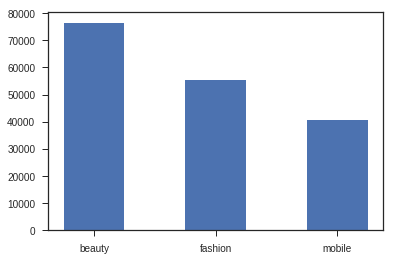

In [0]:
MobileTest = dftest[dftest['newCat'] == 'mobile']
BeautyTest = dftest[dftest['newCat'] == 'beauty']
FashionTest = dftest[dftest['newCat'] == 'fashion']

fig, axt = plt.subplots(1,1)
axt.bar(['beauty', 'fashion', 'mobile'], [len(BeautyTest), len(FashionTest), len(MobileTest)], width=0.5)


### 5.3 Prediction Dataset

In [0]:
B_X_test = BeautyTest.title
F_X_test = FashionTest.title
M_X_test = MobileTest.title

### 5.4 Prediction Function

In [0]:
def modelPredict(X_train, y_train, X_test, vect, 
                 clf=SGDClassifier(random_state=42,max_iter=5000, 
                                            tol=1e-3,loss='hinge')):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)
    
    X_train_dtm,X_test_dtm = tokenize_data(vect, X_train, X_test)
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    return y_pred

In [0]:
B_y_pred = modelPredict(B_X_train, B_y_train, B_X_test, Bs_vect, clf=B_bestModel)

In [0]:
F_y_pred = modelPredict(F_X_train, F_y_train, F_X_test, Fs_vect, clf=bestModel)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 16.55, NNZs: 115832, Bias: -1.674198, T: 219702, Avg. loss: 0.062351
Total training time: 0.30 seconds.
Norm: 61.77, NNZs: 1194350, Bias: -2.215469, T: 219702, Avg. loss: 0.995028
Total training time: 0.30 seconds.
-- Epoch 2
-- Epoch 2
Norm: 13.37, NNZs: 157998, Bias: -1.612929, T: 439404, Avg. loss: 0.023476
Total training time: 0.59 seconds.
-- Epoch 3
Norm: 50.65, NNZs: 1575453, Bias: -1.919359, T: 439404, Avg. loss: 0.320657
Total training time: 0.62 seconds.
-- Epoch 3
Norm: 12.23, NNZs: 195505, Bias: -1.574944, T: 659106, Avg. loss: 0.019529
Total training time: 0.88 seconds.
-- Epoch 4
Norm: 47.62, NNZs: 1733143, Bias: -1.765382, T: 659106, Avg. loss: 0.254415
Total training time: 0.93 seconds.
-- Epoch 4
Norm: 11.66, NNZs: 228572, Bias: -1.545430, T: 878808, Avg. loss: 0.017698
Total training time: 1.15 seconds.
-- Epoch 5
Norm: 46.33, NNZs: 1817839, Bias: -1.665254, T: 878808, Avg. loss: 0.225872
Total training time: 1.23 seconds.
-- Epoch 5
Norm: 

[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   28.3s finished


In [0]:
M_y_pred = modelPredict(M_X_train, M_y_train, M_X_test, Ms_vect, clf=Mo_sgd)

### 5.5 Run Prediction

In [0]:
BeautyTest['Category'] = B_y_pred
FashionTest['Category'] = F_y_pred
MobileTest['Category'] = M_y_pred


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

## 6- Result

In [0]:
resDf = BeautyTest.append(FashionTest).append(MobileTest)


In [0]:
FinalResult = pd.concat([resDf['itemid'], resDf['Category']], axis=1, 
                        keys=['itemid', 'Category'])
FinalResult.to_csv(path + '{}_NDSC_Res.csv'.format(datetime.datetime.today().strftime('%Y%m%d')
                                                  ), index=False)